In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from PIL import Image, ImageOps
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# image directory
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
# get 10 images
image_files = os.listdir(image_dir)[:10]

for i, file_name in enumerate(image_files, 1):
    # iterate over the image files that get and
    # join the path to open each image
    image_path = os.path.join(image_dir, file_name)
    with Image.open(image_path) as img:
        print(f"Image {i}: {file_name} - Size: {img.size}") 

Random Seed:  999
Image 1: ISIC_9730802.jpg - Size: (139, 139)
Image 2: ISIC_2834883.jpg - Size: (125, 125)
Image 3: ISIC_5115027.jpg - Size: (123, 123)
Image 4: ISIC_3264822.jpg - Size: (115, 115)
Image 5: ISIC_1950204.jpg - Size: (147, 147)
Image 6: ISIC_8411738.jpg - Size: (145, 145)
Image 7: ISIC_3744117.jpg - Size: (133, 133)
Image 8: ISIC_0989720.jpg - Size: (131, 131)
Image 9: ISIC_3926794.jpg - Size: (139, 139)
Image 10: ISIC_2892810.jpg - Size: (107, 107)


In [2]:
meta_dir = "/kaggle/input/isic-2024-challenge/"

# read the csv file
df = pd.read_csv(meta_dir + "train-metadata.csv")

# display head
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [3]:
# for training the encoder we need only positive cases
# so others are drop by the dataframe
df_filtered = df[df["target"] == 1].reset_index(drop=True)

# show the new data frame
df_filtered.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846


In [ ]:
import matplotlib.pyplot as plt

# get first 10 isic_ids as sample and view them 
isic_ids = df_filtered['isic_id'].head(10)

# plot the images
plt.figure(figsize=(15, 6))
for i, isic_id in enumerate(isic_ids):
    image_path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = Image.open(image_path).convert("RGB")
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 1. CLAHE contrast enhancement

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/clahe_images'
os.makedirs(save_dir, exist_ok=True)

# Sample image IDs
isic_ids = df_filtered['isic_id'].head(10)

plt.figure(figsize=(15, 6))

for i, isic_id in enumerate(isic_ids):
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = cv2.imread(path)
    if img is None:
        continue  # skip if image not found

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

    # Convert to YUV and apply CLAHE on the luminance channel
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y_channel = yuv[:, :, 0]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    y_clahe = clahe.apply(y_channel)
    yuv[:, :, 0] = y_clahe

    # Convert back to RGB
    clahe_img = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

    # Save (convert back to BGR for OpenCV)
    save_path = os.path.join(save_dir, f"{isic_id}_clahe.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(clahe_img, cv2.COLOR_RGB2BGR))

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(clahe_img)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. CLAHE on the L channel of the Lab color space

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/clahe_images_lab'
os.makedirs(save_dir, exist_ok=True)

# Sample image IDs
isic_ids = df_filtered['isic_id'].head(10)

plt.figure(figsize=(15, 6))

for i, isic_id in enumerate(isic_ids):
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = cv2.imread(path)
    if img is None:
        continue

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

    # Convert to Lab color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    # Merge and convert back to RGB
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2RGB)

    # Save (convert to BGR for OpenCV)
    save_path = os.path.join(save_dir, f"{isic_id}_clahe.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(img_clahe, cv2.COLOR_RGB2BGR))

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_clahe)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Histogram Matching

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

# Paths
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/histogram_matched_images'
os.makedirs(save_dir, exist_ok=True)

# Sample image IDs
isic_ids = df_filtered['isic_id'].head(10)

# Reference image (choose a well-lit image ID from your dataset)
reference_id = df_filtered['isic_id'].iloc[0]  # Use first image as reference
ref_path = os.path.join(image_dir, f"{reference_id}.jpg")
ref = cv2.imread(ref_path)
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
ref = cv2.resize(ref, (128, 128), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(15, 6))

for i, isic_id in enumerate(isic_ids):
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = cv2.imread(path)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

    # Match histogram to the reference image
    matched = match_histograms(img, ref, channel_axis=-1)

    # Save (convert to BGR for OpenCV)
    save_path = os.path.join(save_dir, f"{isic_id}_matched.jpg")
    cv2.imwrite(save_path, cv2.cvtColor((matched * 255).astype('uint8'), cv2.COLOR_RGB2BGR))

    # Plot
    plt.subplot(2, 5, i + 1)
    plt.imshow(matched)
    plt.title(isic_id)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Test with 3 above methods

## 2. CLAHE on the L channel of the Lab color space
## ✅ Step 1: Preprocess and Save Images with CLAHE

In [8]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/clahe_128'
os.makedirs(save_dir, exist_ok=True)

# Filter original data
malignant_df = df[df["target"] == 1]
benign_df = df[df["target"] == 0].sample(n=10000, random_state=42)
df_filtered = pd.concat([malignant_df, benign_df]).reset_index(drop=True)

# Container to track all processed (original + augmented) entries
new_records = []

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def augment_image(img):
    aug_imgs = []
    for angle in [90, 180, 270]:
        rotated = cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        aug_imgs.append(rotated)
        aug_imgs.append(cv2.flip(rotated, 1))  # horizontal flip
    return aug_imgs

# Process and augment images
for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    isic_id = row["isic_id"]
    label = row["target"]
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))

    img = apply_clahe(img)

    # Save original
    save_path = os.path.join(save_dir, f"{isic_id}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    new_records.append({'isic_id': isic_id, 'target': label})

    # Augment only malignant images
    if label == 1:
        aug_imgs = augment_image(img)
        for i, aug_img in enumerate(aug_imgs):
            aug_id = f"{isic_id}_aug{i}"
            aug_path = os.path.join(save_dir, f"{aug_id}.jpg")
            cv2.imwrite(aug_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            new_records.append({'isic_id': aug_id, 'target': 1})

# Final updated dataframe with augmented malignant samples
df_filtered = pd.DataFrame(new_records).reset_index(drop=True)
print(f"Final dataset size: {len(df_filtered)}")
df_filtered.head()

100%|██████████| 10393/10393 [02:07<00:00, 81.26it/s]

Final dataset size: 12751


,isic_id,target
0,ISIC_0082829,1
1,ISIC_0082829_aug0,1
2,ISIC_0082829_aug1,1
3,ISIC_0082829_aug2,1
4,ISIC_0082829_aug3,1


## ✅ Step 2: Custom Dataset Class

In [9]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        isic_id = self.df.iloc[idx]["isic_id"]
        label = self.df.iloc[idx]["target"]
        img_path = os.path.join(self.img_dir, f"{isic_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

## ✅ Step 3: Transforms, Split, and Loaders

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["target"], random_state=42)

train_dataset = SkinLesionDataset(train_df, save_dir, transform)
val_dataset = SkinLesionDataset(val_df, save_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## ✅ Step 4: CNN Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # raw logits

## ✅ Step 5: Train the Model

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, optimizer
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1: Train Loss = 0.4016, Train Acc = 0.8319, Val Loss = 0.3412, Val Acc = 0.8659
Epoch 2: Train Loss = 0.3366, Train Acc = 0.8630, Val Loss = 0.2962, Val Acc = 0.8820
Epoch 3: Train Loss = 0.3261, Train Acc = 0.8686, Val Loss = 0.2873, Val Acc = 0.8800
Epoch 4: Train Loss = 0.3118, Train Acc = 0.8730, Val Loss = 0.2951, Val Acc = 0.8781
Epoch 5: Train Loss = 0.2983, Train Acc = 0.8782, Val Loss = 0.2651, Val Acc = 0.8934
Epoch 6: Train Loss = 0.2789, Train Acc = 0.8833, Val Loss = 0.2716, Val Acc = 0.8898
Epoch 7: Train Loss = 0.2560, Train Acc = 0.8931, Val Loss = 0.2551, Val Acc = 0.8985
Epoch 8: Train Loss = 0.2361, Train Acc = 0.9017, Val Loss = 0.2630, Val Acc = 0.8965
Epoch 9: Train Loss = 0.2149, Train Acc = 0.9111, Val Loss = 0.2476, Val Acc = 0.9024
Epoch 10: Train Loss = 0.1837, Train Acc = 0.9234, Val Loss = 0.2663, Val Acc = 0.8938


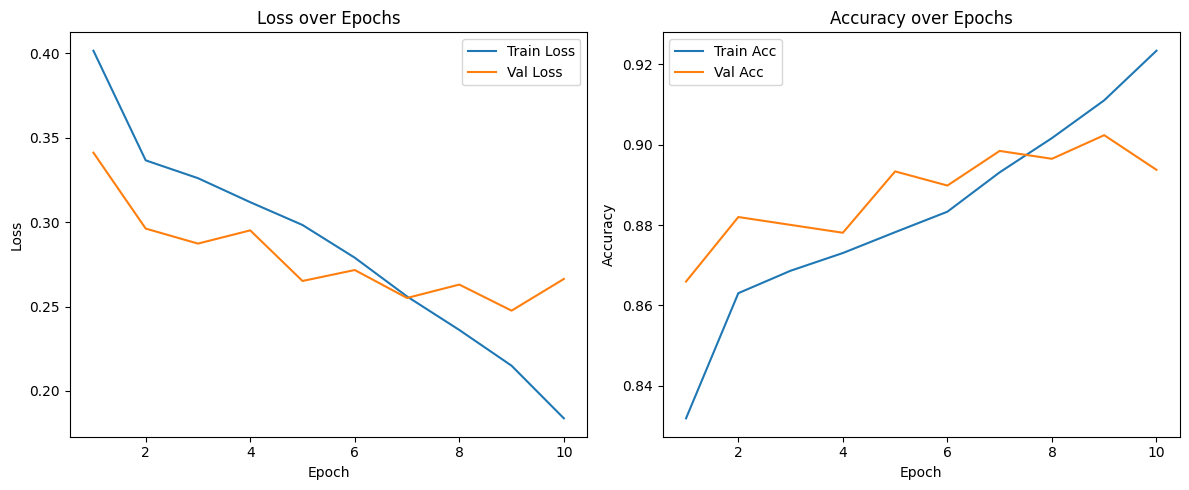

In [13]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

# Metric storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        train_preds.extend(preds.flatten())
        train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            val_preds.extend(preds.flatten())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

# Plotting
epochs = range(1, 11)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## 0. Without any enhancement

In [14]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/without_any'
os.makedirs(save_dir, exist_ok=True)

# keep all malignant and 10,000 benign
malignant_df = df[df["target"] == 1]
benign_df = df[df["target"] == 0].sample(n=10000, random_state=42)
df_filtered = pd.concat([malignant_df, benign_df]).reset_index(drop=True)

# Store all records including augmented ones
new_records = []

def augment_image(img):
    aug_imgs = []
    for angle in [90, 180, 270]:
        rotated = cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        aug_imgs.append(rotated)
        aug_imgs.append(cv2.flip(rotated, 1))  # horizontal flip
    return aug_imgs

for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    isic_id = row["isic_id"]
    label = row["target"]
    path = os.path.join(image_dir, f"{isic_id}.jpg")
    
    img = cv2.imread(path)
    img = cv2.resize(img, (128, 128))

    # Save original
    out_path = os.path.join(save_dir, f"{isic_id}.jpg")
    cv2.imwrite(out_path, img)
    new_records.append({'isic_id': isic_id, 'target': label})

    # Augment if malignant
    if label == 1:
        aug_imgs = augment_image(img)
        for i, aug_img in enumerate(aug_imgs):
            aug_id = f"{isic_id}_aug{i}"
            aug_path = os.path.join(save_dir, f"{aug_id}.jpg")
            cv2.imwrite(aug_path, aug_img)
            new_records.append({'isic_id': aug_id, 'target': 1})

# Create final DataFrame
df_filtered = pd.DataFrame(new_records).reset_index(drop=True)
print(f"Final dataset size: {len(df_filtered)}")
df_filtered.head()

100%|██████████| 10393/10393 [00:14<00:00, 704.14it/s]

Final dataset size: 12751


,isic_id,target
0,ISIC_0082829,1
1,ISIC_0082829_aug0,1
2,ISIC_0082829_aug1,1
3,ISIC_0082829_aug2,1
4,ISIC_0082829_aug3,1


## ✅ Step 2: Custom Dataset Class

In [15]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        isic_id = self.df.iloc[idx]["isic_id"]
        label = self.df.iloc[idx]["target"]
        img_path = os.path.join(self.img_dir, f"{isic_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

## ✅ Step 3: Transforms, Split, and Loaders

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["target"], random_state=42)

train_dataset = SkinLesionDataset(train_df, save_dir, transform)
val_dataset = SkinLesionDataset(val_df, save_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## ✅ Step 4: CNN Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # raw logits

## ✅ Step 5: Train the Model

In [18]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, optimizer
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1: Train Loss = 0.4158, Train Acc = 0.8299, Val Loss = 0.3327, Val Acc = 0.8648
Epoch 2: Train Loss = 0.3460, Train Acc = 0.8613, Val Loss = 0.3123, Val Acc = 0.8789
Epoch 3: Train Loss = 0.3288, Train Acc = 0.8665, Val Loss = 0.3261, Val Acc = 0.8652
Epoch 4: Train Loss = 0.3207, Train Acc = 0.8733, Val Loss = 0.3151, Val Acc = 0.8722
Epoch 5: Train Loss = 0.3062, Train Acc = 0.8739, Val Loss = 0.2761, Val Acc = 0.8946
Epoch 6: Train Loss = 0.2937, Train Acc = 0.8791, Val Loss = 0.2756, Val Acc = 0.8871
Epoch 7: Train Loss = 0.2785, Train Acc = 0.8875, Val Loss = 0.2535, Val Acc = 0.9063
Epoch 8: Train Loss = 0.2695, Train Acc = 0.8873, Val Loss = 0.2509, Val Acc = 0.8977
Epoch 9: Train Loss = 0.2540, Train Acc = 0.8941, Val Loss = 0.2981, Val Acc = 0.8895
Epoch 10: Train Loss = 0.2515, Train Acc = 0.8940, Val Loss = 0.2483, Val Acc = 0.8993


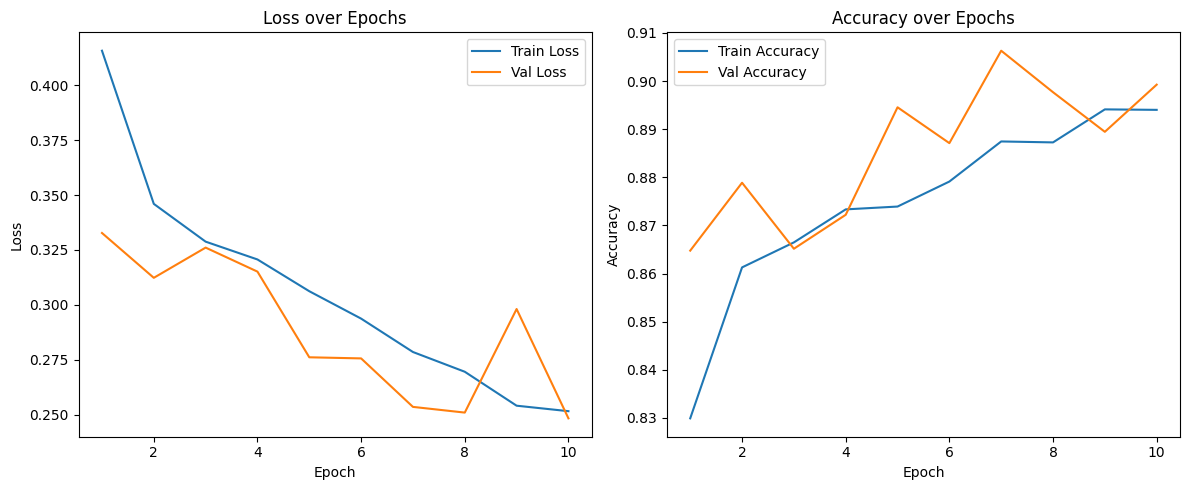

In [19]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

# Store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        train_preds.extend(preds.flatten())
        train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            val_preds.extend(preds.flatten())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

# Plotting
epochs = range(1, 11)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# debug code check whether the id in images are same
import os

save_dir1 = '/kaggle/working/without_any'
save_dir2 = '/kaggle/working/clahe_128'

# Get image IDs (filenames without extension)
ids1 = {os.path.splitext(f)[0] for f in os.listdir(save_dir1) if f.endswith(('.jpg', '.png'))}
ids2 = {os.path.splitext(f)[0] for f in os.listdir(save_dir2) if f.endswith(('.jpg', '.png'))}

# Compare
only_in_1 = ids1 - ids2
only_in_2 = ids2 - ids1
common = ids1 & ids2

print(f"Total in dir1: {len(ids1)}")
print(f"Total in dir2: {len(ids2)}")
print(f"Common: {len(common)}")

if only_in_1:
    print(f"Only in dir1: {sorted(only_in_1)}")
if only_in_2:
    print(f"Only in dir2: {sorted(only_in_2)}")

if not only_in_1 and not only_in_2:
    print("✅ Both directories have the same image IDs.")
else:
    print("❌ Directories do not match.")


Total in dir1: 12751
Total in dir2: 12751
Common: 12751
✅ Both directories have the same image IDs.


## 1. CLAHE contrast enhancement
## ✅ Step 1: Preprocess and Save Images with CLAHE

In [21]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/clahe_normal'
os.makedirs(save_dir, exist_ok=True)

# Filter data
malignant_df = df[df["target"] == 1]
benign_df = df[df["target"] == 0].sample(n=10000, random_state=42)
df_filtered = pd.concat([malignant_df, benign_df]).reset_index(drop=True)

# Record for final dataframe
new_records = []

def apply_clahe_yuv(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    y_channel = yuv[:, :, 0]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    yuv[:, :, 0] = clahe.apply(y_channel)
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)

def augment_image(img):
    aug_imgs = []
    for angle in [90, 180, 270]:
        rotated = cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        aug_imgs.append(rotated)
        aug_imgs.append(cv2.flip(rotated, 1))  # horizontal flip
    return aug_imgs

# Preprocess and augment
for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    isic_id = row["isic_id"]
    label = row["target"]
    img_path = os.path.join(image_dir, f"{isic_id}.jpg")
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

    # Apply CLAHE on Y channel
    img = apply_clahe_yuv(img)

    # Save original
    save_path = os.path.join(save_dir, f"{isic_id}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    new_records.append({'isic_id': isic_id, 'target': label})

    # Augment if malignant
    if label == 1:
        aug_imgs = augment_image(img)
        for i, aug_img in enumerate(aug_imgs):
            aug_id = f"{isic_id}_aug{i}"
            aug_path = os.path.join(save_dir, f"{aug_id}.jpg")
            cv2.imwrite(aug_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            new_records.append({'isic_id': aug_id, 'target': 1})

# Final dataset with all images
df_filtered = pd.DataFrame(new_records).reset_index(drop=True)
print(f"Final dataset size: {len(df_filtered)}")
df_filtered.head()

100%|██████████| 10393/10393 [00:22<00:00, 455.96it/s]

Final dataset size: 12751


,isic_id,target
0,ISIC_0082829,1
1,ISIC_0082829_aug0,1
2,ISIC_0082829_aug1,1
3,ISIC_0082829_aug2,1
4,ISIC_0082829_aug3,1


## ✅ Step 2: Custom Dataset Class

In [22]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        isic_id = self.df.iloc[idx]["isic_id"]
        label = self.df.iloc[idx]["target"]
        img_path = os.path.join(self.img_dir, f"{isic_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

## ✅ Step 3: Transforms, Split, and Loaders

In [23]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["target"], random_state=42)

train_dataset = SkinLesionDataset(train_df, save_dir, transform)
val_dataset = SkinLesionDataset(val_df, save_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## ✅ Step 4: CNN Model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # raw logits

In [25]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, optimizer
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## ✅ Step 5: Train the Model

Epoch 1: Train Loss = 0.3974, Train Acc = 0.8356, Val Loss = 0.3111, Val Acc = 0.8730
Epoch 2: Train Loss = 0.3357, Train Acc = 0.8638, Val Loss = 0.3281, Val Acc = 0.8573
Epoch 3: Train Loss = 0.3158, Train Acc = 0.8714, Val Loss = 0.2845, Val Acc = 0.8820
Epoch 4: Train Loss = 0.3000, Train Acc = 0.8794, Val Loss = 0.2778, Val Acc = 0.8816
Epoch 5: Train Loss = 0.2779, Train Acc = 0.8839, Val Loss = 0.2730, Val Acc = 0.8914
Epoch 6: Train Loss = 0.2641, Train Acc = 0.8890, Val Loss = 0.2697, Val Acc = 0.8863
Epoch 7: Train Loss = 0.2461, Train Acc = 0.8953, Val Loss = 0.2673, Val Acc = 0.8895
Epoch 8: Train Loss = 0.2170, Train Acc = 0.9064, Val Loss = 0.2733, Val Acc = 0.8871
Epoch 9: Train Loss = 0.1937, Train Acc = 0.9188, Val Loss = 0.2681, Val Acc = 0.8906
Epoch 10: Train Loss = 0.1699, Train Acc = 0.9285, Val Loss = 0.3246, Val Acc = 0.8879


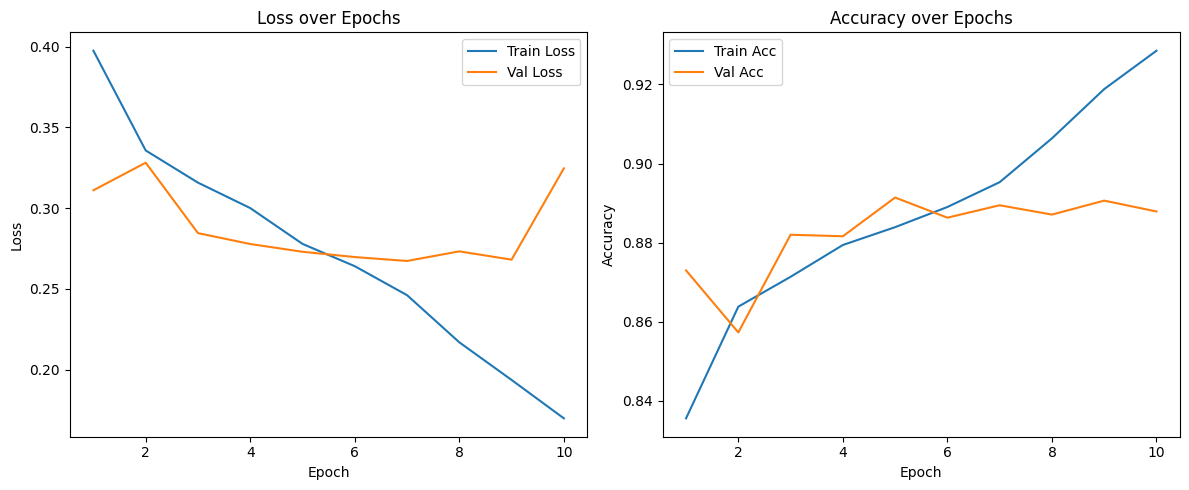

In [26]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

# Enable metric tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        train_preds.extend(preds.flatten())
        train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            val_preds.extend(preds.flatten())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

# Plotting
epochs = range(1, 11)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Histogram Matching
## ✅ Step 1: Preprocess and Save Images with CLAHE

In [27]:
import os
import cv2
import pandas as pd
from tqdm import tqdm
from skimage.exposure import match_histograms

image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'
save_dir = '/kaggle/working/histogram_matched_images'
os.makedirs(save_dir, exist_ok=True)

# Load and resize reference image for histogram matching
ref_path = os.path.join(image_dir, 'ISIC_0052109.jpg')  # Replace with actual ID
ref = cv2.imread(ref_path)
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
ref = cv2.resize(ref, (128, 128), interpolation=cv2.INTER_CUBIC)

# Filter data
malignant_df = df[df["target"] == 1]
benign_df = df[df["target"] == 0].sample(n=10000, random_state=42)
df_filtered = pd.concat([malignant_df, benign_df]).reset_index(drop=True)

# Store all records
new_records = []

def augment_image(img):
    aug_imgs = []
    for angle in [90, 180, 270]:
        rotated = cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])
        aug_imgs.append(rotated)
        aug_imgs.append(cv2.flip(rotated, 1))  # horizontal flip
    return aug_imgs

# Process and augment images
for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    isic_id = row["isic_id"]
    label = row["target"]
    path = os.path.join(image_dir, f"{isic_id}.jpg")

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)

    # Histogram matching
    matched = match_histograms(img, ref, channel_axis=-1)
    matched = (matched * 255).astype('uint8')

    # Save original
    save_path = os.path.join(save_dir, f"{isic_id}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(matched, cv2.COLOR_RGB2BGR))
    new_records.append({'isic_id': isic_id, 'target': label})

    # Augment malignant
    if label == 1:
        aug_imgs = augment_image(matched)
        for i, aug_img in enumerate(aug_imgs):
            aug_id = f"{isic_id}_aug{i}"
            aug_path = os.path.join(save_dir, f"{aug_id}.jpg")
            cv2.imwrite(aug_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            new_records.append({'isic_id': aug_id, 'target': 1})

# Final DataFrame
df_filtered = pd.DataFrame(new_records).reset_index(drop=True)
print(f"Final dataset size: {len(df_filtered)}")
df_filtered.head()

100%|██████████| 10393/10393 [00:24<00:00, 429.15it/s]

Final dataset size: 12751


,isic_id,target
0,ISIC_0082829,1
1,ISIC_0082829_aug0,1
2,ISIC_0082829_aug1,1
3,ISIC_0082829_aug2,1
4,ISIC_0082829_aug3,1


## ✅ Step 2: Custom Dataset Class

In [28]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        isic_id = self.df.iloc[idx]["isic_id"]
        label = self.df.iloc[idx]["target"]
        img_path = os.path.join(self.img_dir, f"{isic_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

## ✅ Step 3: Transforms, Split, and Loaders

In [29]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_df, val_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered["target"], random_state=42)

train_dataset = SkinLesionDataset(train_df, save_dir, transform)
val_dataset = SkinLesionDataset(val_df, save_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## ✅ Step 4: CNN Model

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x  # raw logits

## ✅ Step 5: Train the Model

In [31]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, optimizer
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1: Train Loss = 0.4218, Train Acc = 0.8223, Val Loss = 0.3453, Val Acc = 0.8691
Epoch 2: Train Loss = 0.3391, Train Acc = 0.8600, Val Loss = 0.3230, Val Acc = 0.8734
Epoch 3: Train Loss = 0.3116, Train Acc = 0.8694, Val Loss = 0.3351, Val Acc = 0.8616
Epoch 4: Train Loss = 0.2832, Train Acc = 0.8819, Val Loss = 0.2976, Val Acc = 0.8785
Epoch 5: Train Loss = 0.2535, Train Acc = 0.8926, Val Loss = 0.3050, Val Acc = 0.8789
Epoch 6: Train Loss = 0.2218, Train Acc = 0.9066, Val Loss = 0.3064, Val Acc = 0.8702
Epoch 7: Train Loss = 0.1807, Train Acc = 0.9207, Val Loss = 0.3303, Val Acc = 0.8667
Epoch 8: Train Loss = 0.1426, Train Acc = 0.9389, Val Loss = 0.4246, Val Acc = 0.8612
Epoch 9: Train Loss = 0.1064, Train Acc = 0.9553, Val Loss = 0.4535, Val Acc = 0.8691
Epoch 10: Train Loss = 0.0908, Train Acc = 0.9636, Val Loss = 0.5061, Val Acc = 0.8616


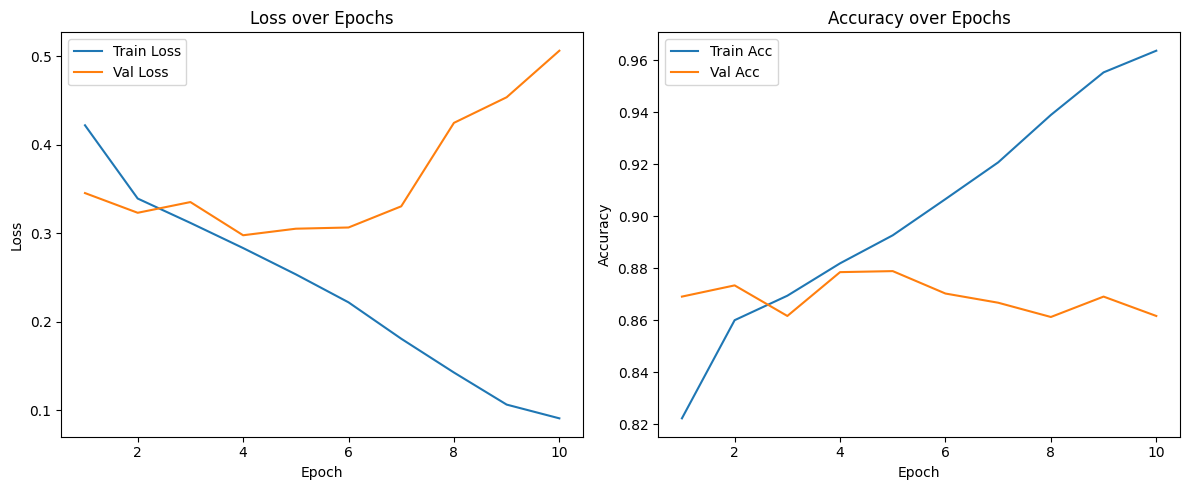

In [32]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch

# Initialize metric lists
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    train_preds, train_labels = [], []

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
        logits = model(imgs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        preds = torch.sigmoid(logits).detach().cpu().numpy() > 0.5
        train_preds.extend(preds.flatten())
        train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.sigmoid(logits).cpu().numpy() > 0.5
            val_preds.extend(preds.flatten())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}")

# Plot training & validation loss and accuracy
epochs = range(1, 11)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()